Nesse caderno, vamos juntar os metadados das pinturas e as coordenadas geradas pelo t-SNE para tentar entender os padrões que o algoritmo encontrou.

#### Importar pacotes

In [7]:
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
from PIL import Image
%matplotlib inline

#### Ler e configurar arquivos

In [8]:
DF = pd.read_csv("../output/tsne-2019-08-16_13-45.csv")

In [9]:
METADATA = pd.read_csv("../data/prado/museo-del-prado_Pintura.tsv", sep = "\t")

In [10]:
METADATA.columns = [ "autor", 
                     "dimensao",
                     "data", 
                     "img", 
                     "procedencia", 
                     "serie", 
                     "suporte", 
                     "tipo", 
                     "tecnica",
                     "titulo",
                     "url",
                     "local" ]

In [11]:
DF = DF.merge(METADATA, on = 'img')

#### Qual o formato geral do banco de dados?

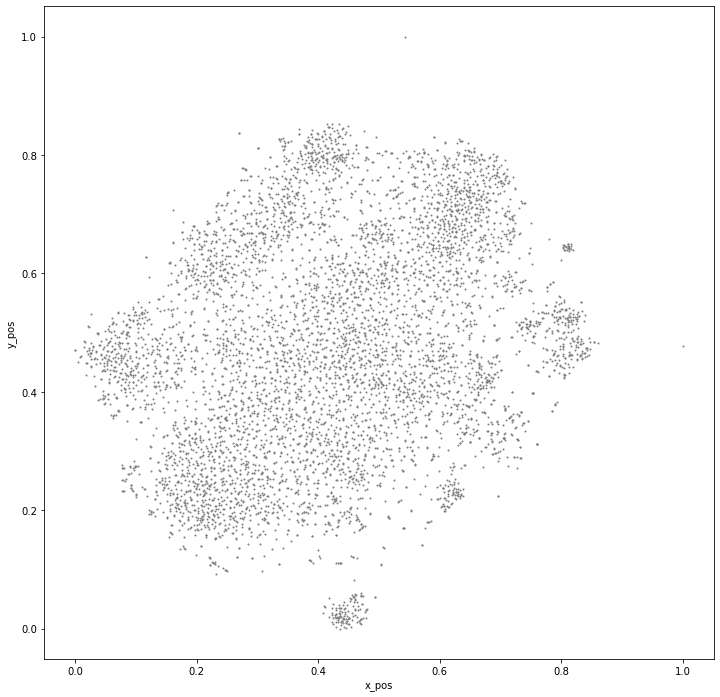

In [12]:
DF.plot(kind = 'scatter', x = 'x_pos', y = 'y_pos', color = 'grey', s = 1, figsize = (12,12))

#### Exploração inicial: conseguimos encontrar clusters por tipo de suporte ou técnica usada?

In [13]:
def highlight_value(df, column, value, figsize=(8,8), s = 2):
    '''
    Destaca, no scatter plot, um valor
    específico da coluna selecionada.
    Todos os demais pontos são pintados
    de cinza, mas os destaques aparecem
    em vermelho.
    '''
    
    ax = df.plot(kind = 'scatter', 
                 x = 'x_pos', 
                 y = 'y_pos',
                 color = 'lightgrey',
                 s = s,
                 figsize = figsize)
    
    df [ df[column] == value ].plot(kind = 'scatter', 
                                    x = 'x_pos', 
                                    y = 'y_pos', 
                                    s = s,
                                    color='red',
                                    ax = ax)
    
    ax.set_title(value)

In [14]:
def show_img(img, make_array = False):
    '''
    Carrega e mostra na tela uma imagem específica.
    O parâmetro `img` é o identifacor da imagem,
    ou seja, a coluna 'img' do dataframe. Caso
    o usuário especifique, a função pode
    simplesmente retornar o array de bites
    da imagem.
    '''
    
    path = "../data/prado/Pintura/"
    file = f"{path}{img}.jpg"
    
    out = Image.open(file, 'r')
    out = np.asarray(out)
    
    if not make_array:
        plt.imshow(out)
        return None
    
    else:
        return out

In [15]:
# Seleciona os autores mais frequentes no dataframe
MOST_FREQUENT_AUTHORS = DF.autor.value_counts().to_frame().reset_index().rename(columns={"index":"autor", "autor":"count"}).autor.head(11).tolist()
MOST_FREQUENT_AUTHORS.remove("Anónimo")

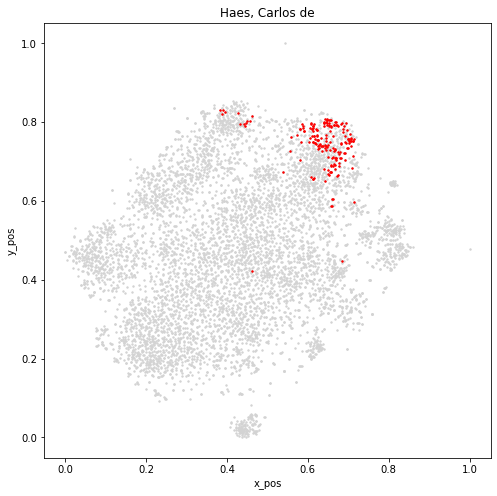

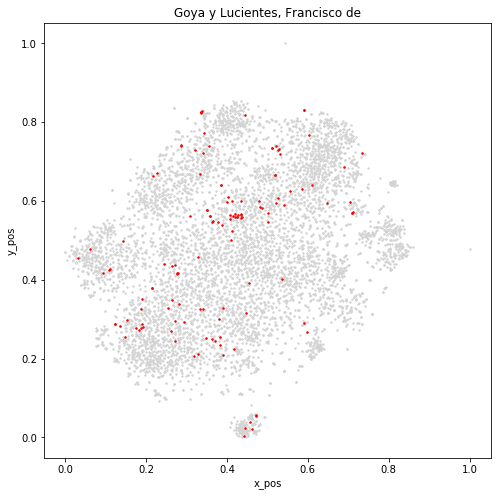

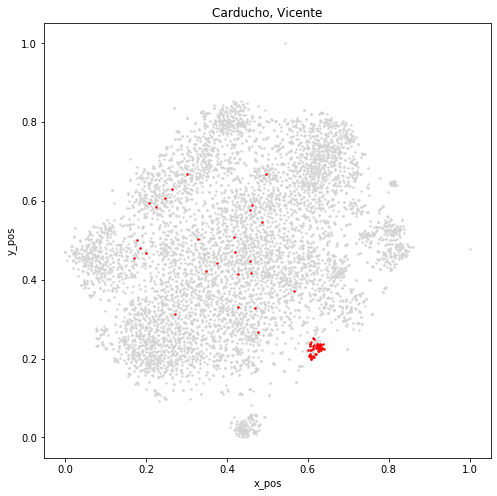

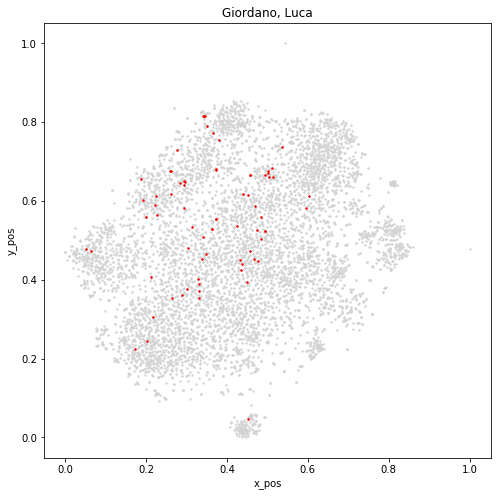

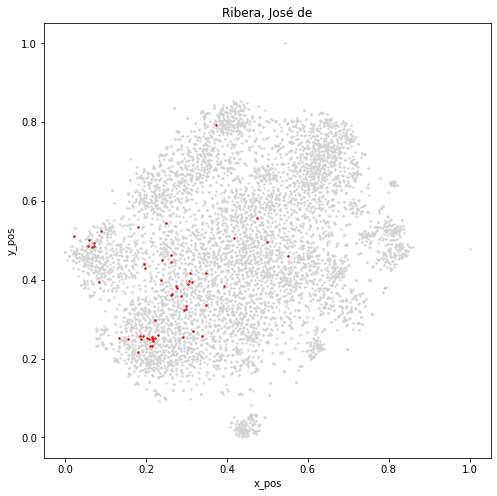

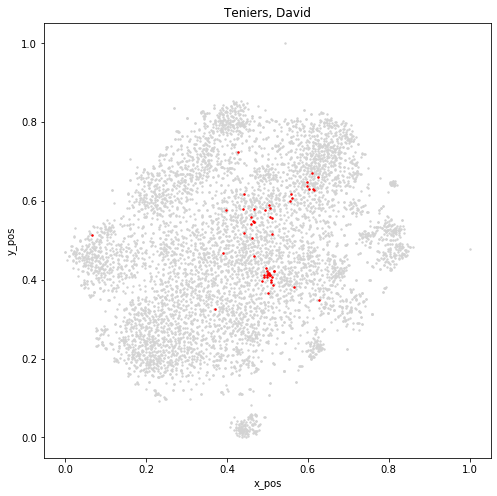

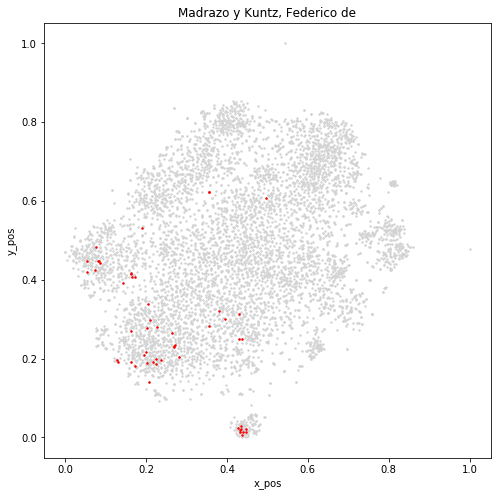

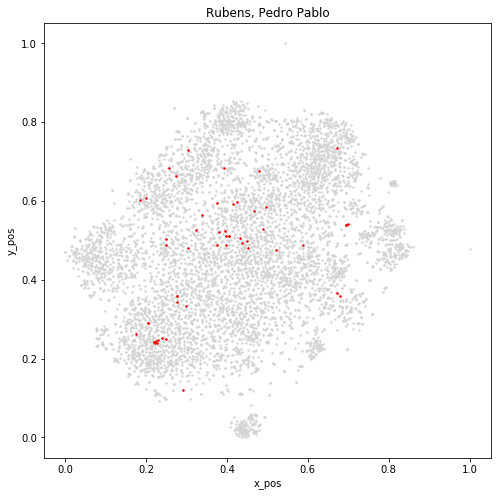

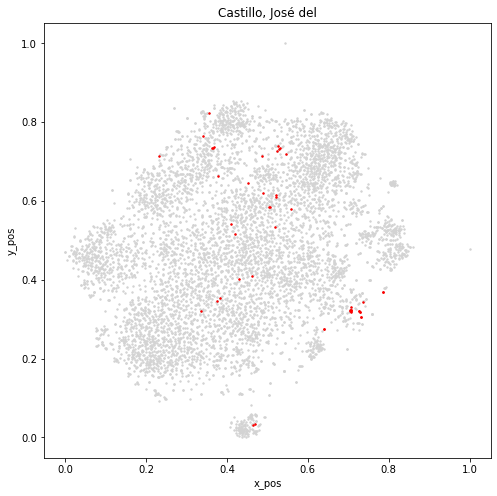

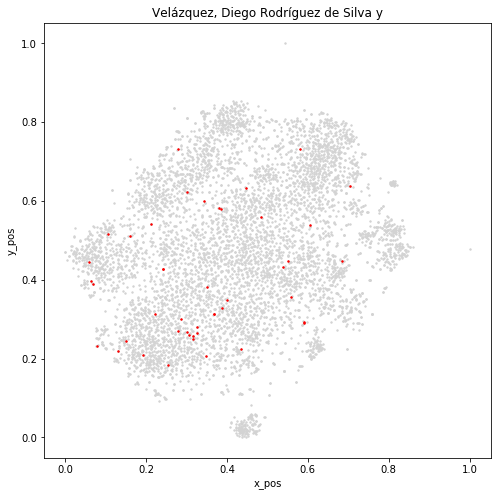

In [16]:
# Vamos descobrir se há clusters dos 10 artistas mais comuns:
for item in MOST_FREQUENT_AUTHORS:
    highlight_value(DF, "autor", item)

Agora, vamos explorar **dentro** desses clusters: vamos plotar, lado a lado, uma imagem e sua própria projeção no plano.

In [17]:
def plot_image_and_position(df, column, value, img, s = 2, figsize = (12, 4)):
    '''
    Desenha, lado a lado, um scatter plot e a imagem de uma pintura.
    No scatter plot, estão destacadas os pontos onde `df.column == value`
    (como df.autor == "Diego Velázques"), por exemplo, em vermelho.
    A obra cujo id foi passda na variável img fica destacada em azul.
    '''
    
    fig = plt.figure()

    # Divide the figure into a 2x1 grid, and give me the first section
    ax1 = fig.add_subplot(1, 2, 1)

    # Divide the figure into a 2x1 grid, and give me the second section
    ax2 = fig.add_subplot(1, 2, 2) 
    
    # Plota todos os pontos
    df.plot(kind = 'scatter', 
                 x = 'x_pos', 
                 y = 'y_pos',
                 color = 'lightgrey',
                 s = s,
                 figsize = figsize,
                 ax = ax1)
    
    # Plota os pontos da categoria selecionada
    df [ df[column] == value ].plot(kind = 'scatter', 
                                    x = 'x_pos', 
                                    y = 'y_pos', 
                                    s = s,
                                    color = 'red',
                                    ax = ax1)
    
    # Plota a imagem selecionada com outra cor
    df [ df.img == img ].plot(kind = 'scatter', 
                                    x = 'x_pos', 
                                    y = 'y_pos', 
                                    s = s * 2,
                                    color = 'blue',
                                    ax = ax1)
    
    # Destaca a imagem específica
    ax2.imshow(show_img(img, True))
    
    cat_title = f"{value}"
    img_title = f"{value} – Imagem {img}"
    
    ax1.set_title(cat_title)
    ax2.set_title(img_title)

In [22]:
def get_n_closest_images(data, img, n = None):
    '''
    Retorna um dataframe com as 'n' pinturas mais próximas 
    daquela cujo id foi passado na variável 'img'.
    '''
    
    def compute_distance(row, coords):
        '''
        Computa a distância entre o ponto x1,y1
        da linha em questão e o ponto x2,y2 que
        foi passada na variável coords.
        '''

        distance = math.sqrt( (row.x_pos - coords["x_pos"])**2 + (row.y_pos - coords["y_pos"])**2 )

        return pd.Series({
            "distance" : distance
        })
    
    # Seleciona a imagem e reindexa
    temp = data [ data.img == img ]
    assert temp.shape[0] == 1
    temp = temp.reset_index()
    
    # Faz uma cópia da variável data para evitar mudanças inplace
    dists = data.copy()
    
    # Calcula a distância em relação às coordenadas da iamgem
    coords = {"x_pos" : temp.loc[0, 'x_pos'], "y_pos" : temp.loc[0, 'y_pos'] }
    dists["distance"] = dists.apply(compute_distance, args = [coords], axis = 1)
    
    # Reordena para que as obras fiquem em ordem de distância
    dists = dists.sort_values(by = "distance")
    
    if n is not None:
        dists = dists.head(n)
    
    return dists

In [ ]:
for author in MOST_FREQUENT_AUTHORS:
        
    # Filtra para manter as obras do autor e ordena
    # para que a primeira seja a que está mais próxima
    # da coordenada 0,0
    TEMP = DF [ DF.autor == author]
    TEMP = TEMP.sort_values(by = "x_pos").sort_values(by = "y_pos")
    TEMP = TEMP.reset_index()
    
    # Computa a distância de todas as obras para a 1º obra
    IMG = TEMP.loc[0, 'img']
    TEMP = get_n_closest_images(DF, IMG)
    
    # Desenha todas as obras 
    for index, row in TEMP.iterrows():
        plot_image_and_position(DF, "autor", row.autor, row.img)

/Users/rs116474/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


In [ ]:
TEMP

Agora, vamos olhar para algumas das principais obras do museu e procurar quais são seus vizinhos – ou seja, obras supostamente parecidas.

Primeiro, as 50 obras mais próximas de "Las Meninas", de Diego Velázquez, que tem o id `P001174`.

In [ ]:
get_n_closest_images(DF, "P001174", 50)